This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_tellurium_ex
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 50.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 1000, 10000])

k11_mean = 0.1
k12_mean = 0.11

test1 = Test(model=model_tellurium_ex({'k1': ('norm', (k11_mean, k11_mean / 10))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_tellurium_ex({'k1': ('norm', (k12_mean, k11_mean / 10))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

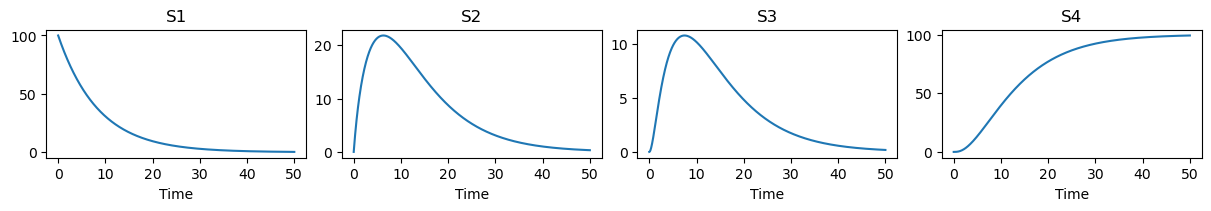

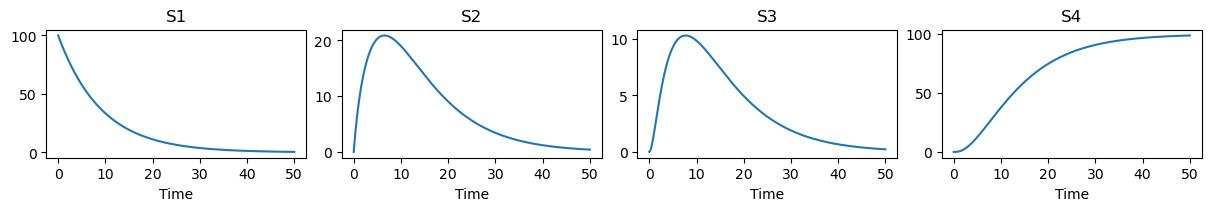

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

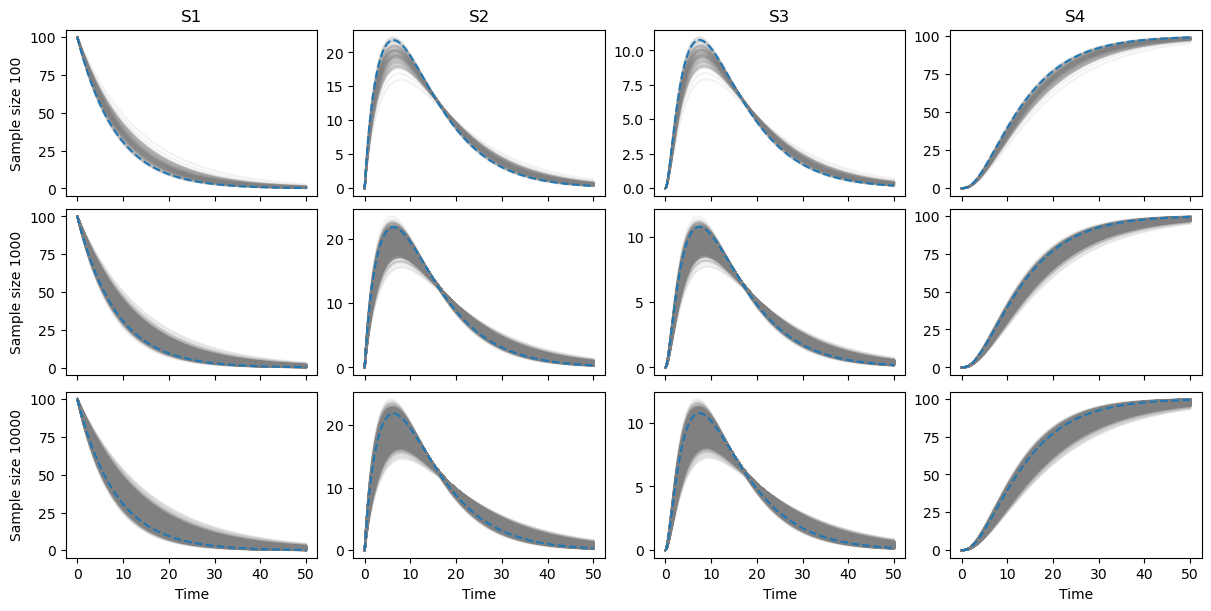

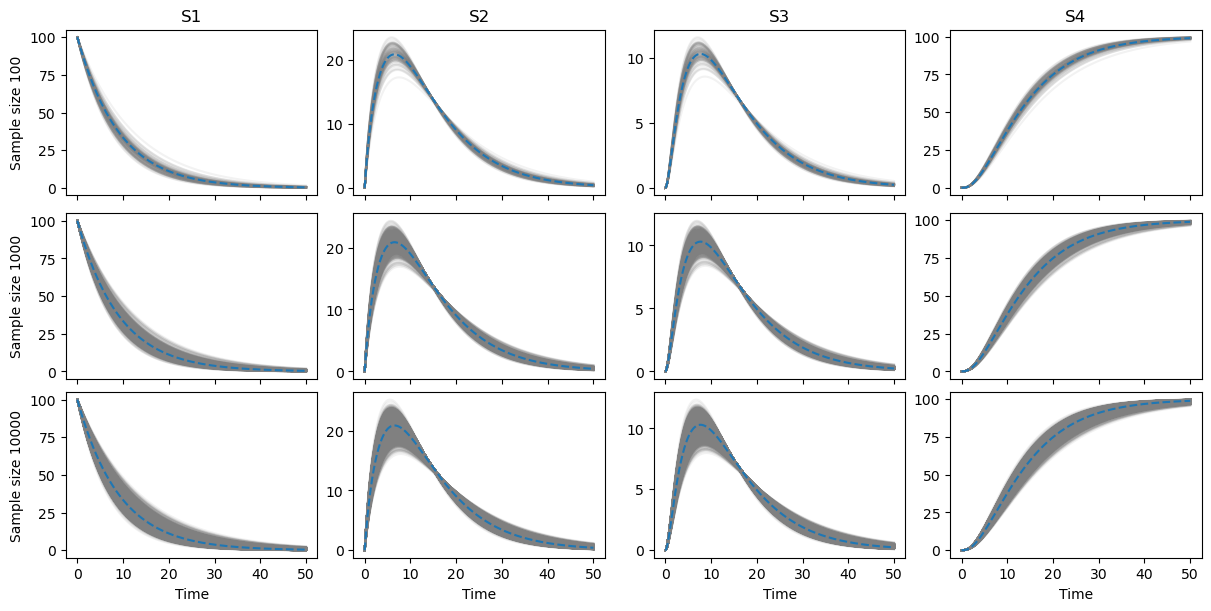

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

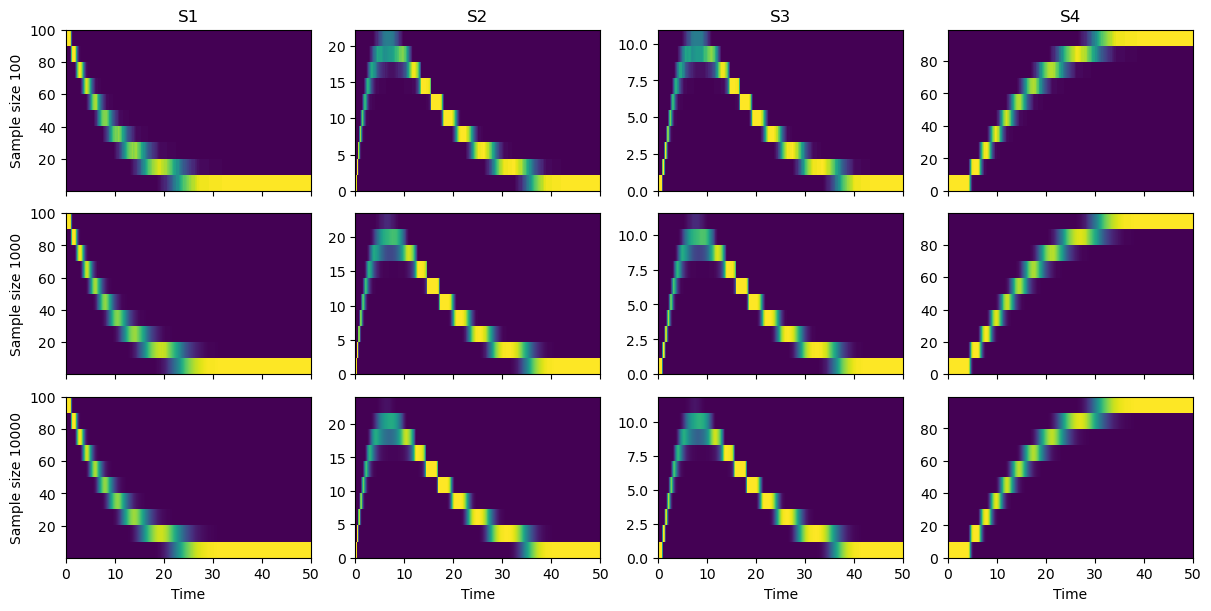

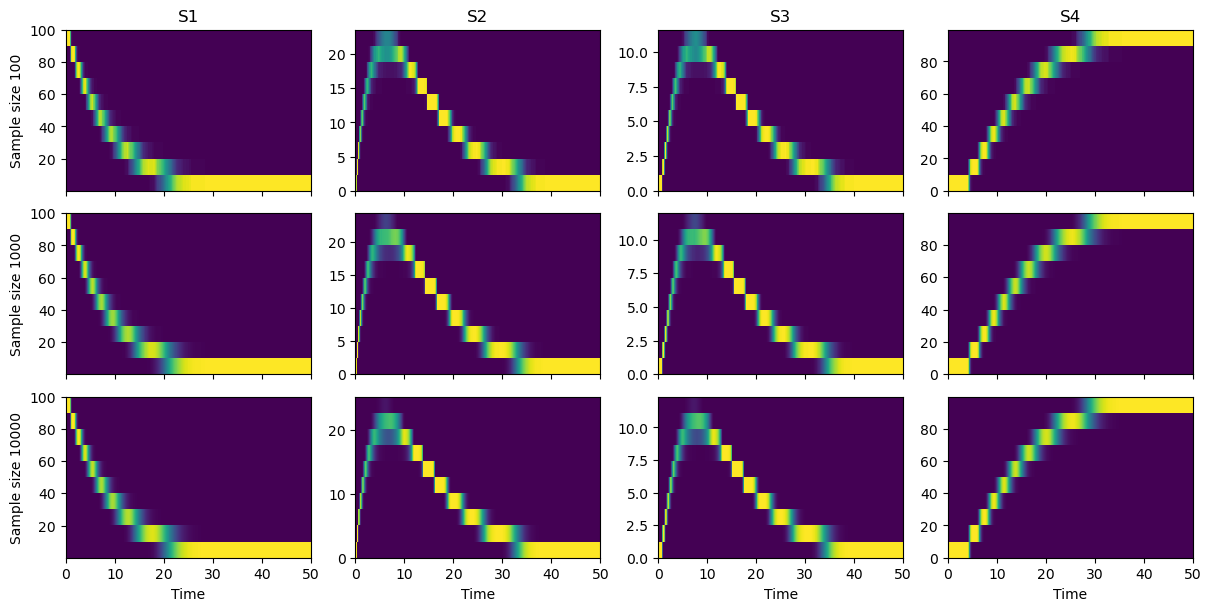

In [5]:
for test in tests:
    _ = test.plot_distributions()

Output()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


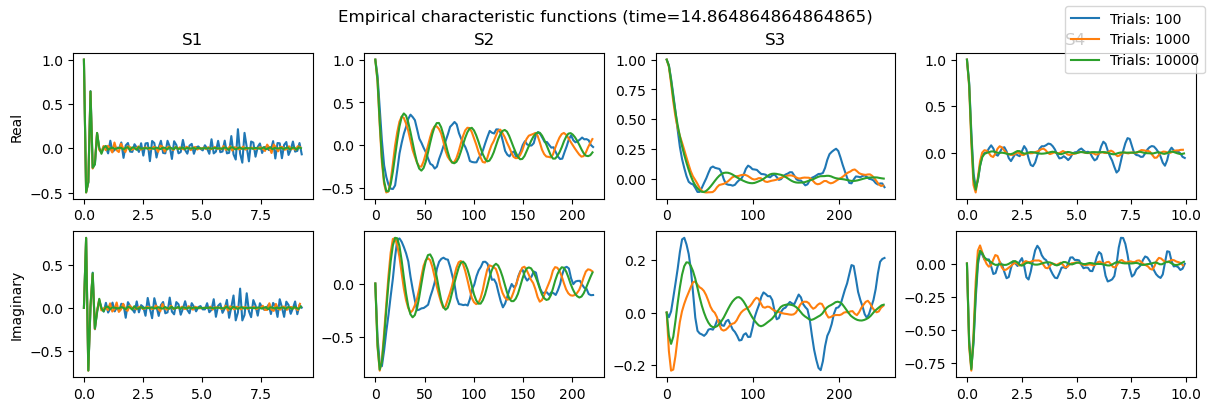

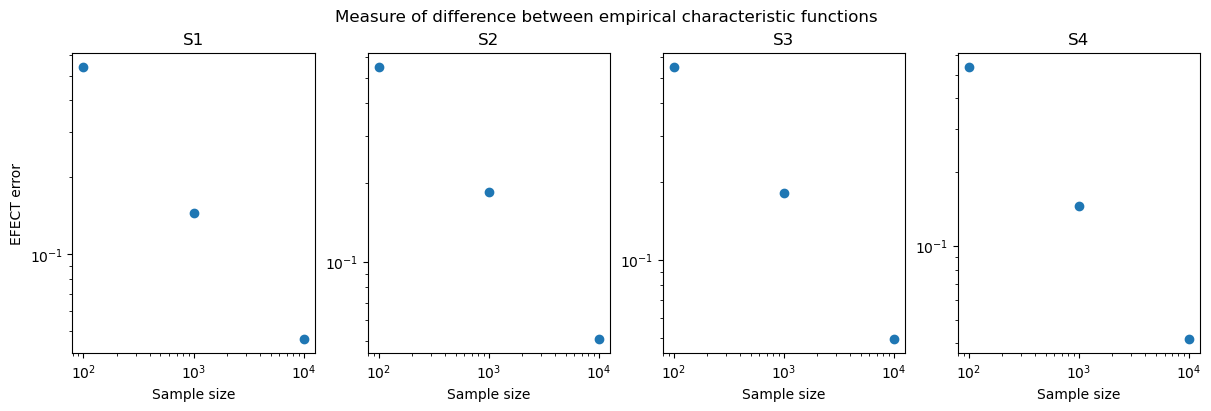

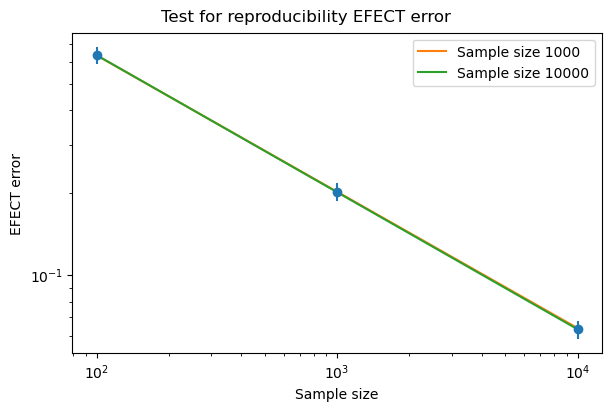

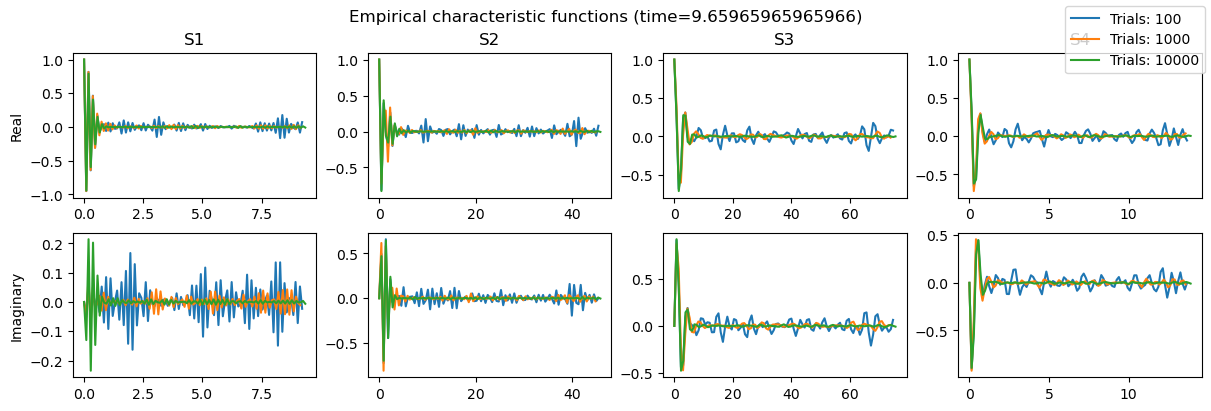

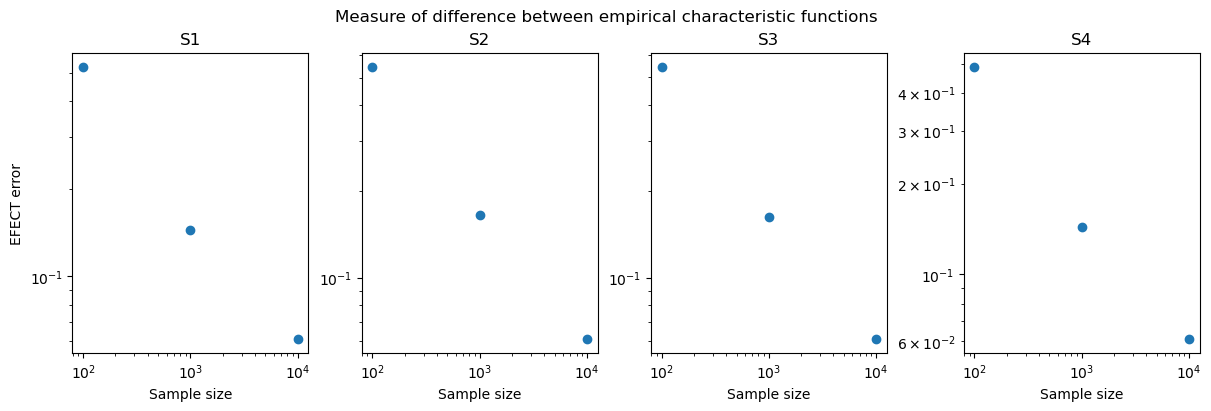

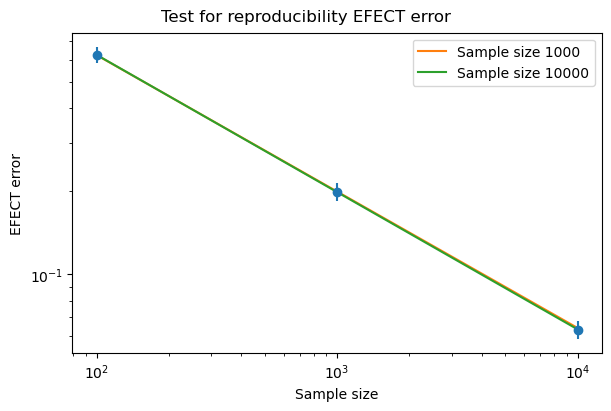

In [6]:
out = ipw.Output()
display(out)

# Runtime: ~222 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    with out:
        test.test_sampling(err_thresh=1E-3, quiet=False)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

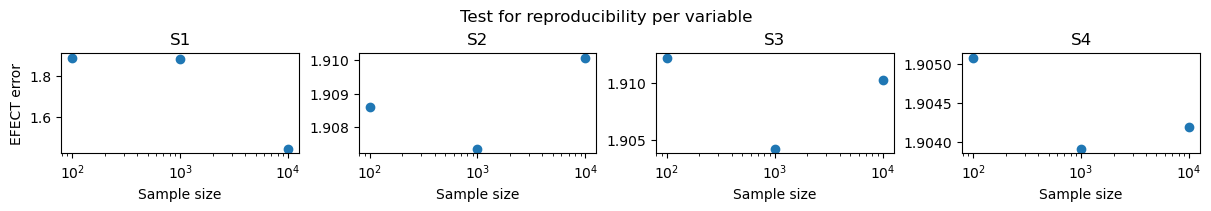

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in model parameters. 

Output()

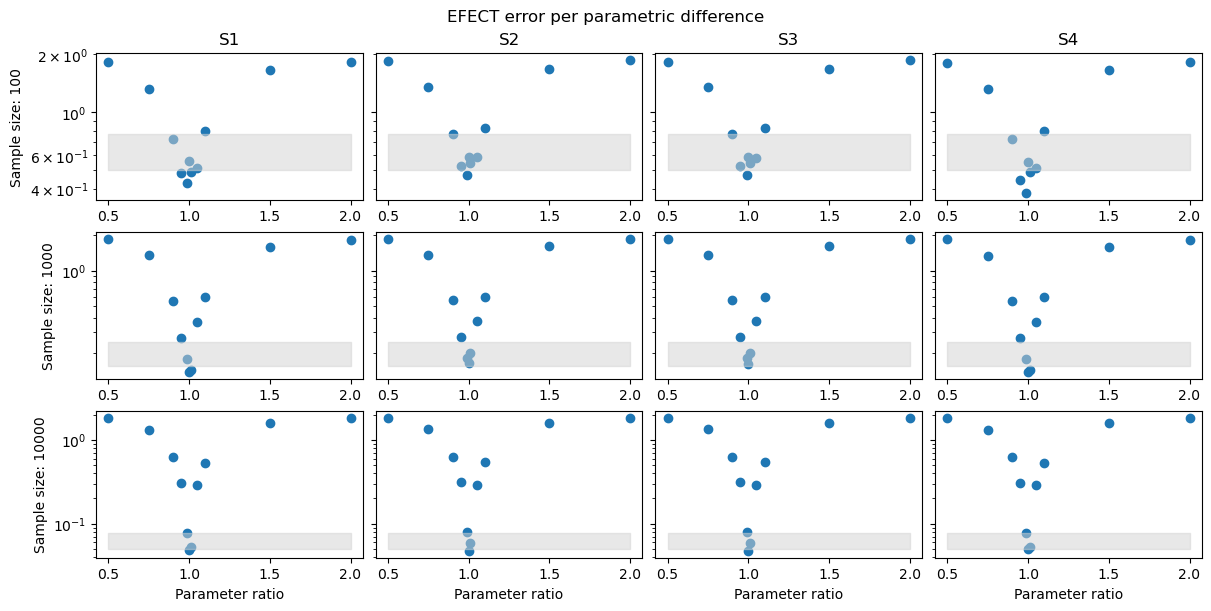

In [8]:
k1_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
k1_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in k1_fact:
    label.value = f'Factor: {bf}...'

    k1test_mean = k11_mean * bf
    test = Test(model=model_tellurium_ex({'k1': ('norm', (k1test_mean, k1test_mean / 10))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    k1_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(k1_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in k1_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(k1_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    sz = len(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in k1_comp]
    q2 = (sz + 1) / sz * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sz + 1) / sz * ((sz - 1) / l2 + 1)) / (sz + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(k1_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.636673,0.044765
1000,0.201716,0.015484
10000,0.063205,0.004649


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           1.840057     26.882257         0.003322                    100   
            0.75           1.350600     15.948318         0.006645                    100   
            0.90           0.769358     2.964020          0.116279                    100   
            0.95           0.527681    -2.434771          1.000000                    100   
            0.99           0.471966    -3.679389          1.000000                    100   
            1.00           0.586716    -1.115993          1.000000                    100   
            1.01           0.545012    -2.047613          1.000000                    100   
            1.05           0.582867    -1.201964          1.000000                    100   
            1.10           0.826119     4.232002          0.056478                    100   
            1.50           1.674454     23.182872         0.003322                    100   
            2.00           1.878110     27.732322         0.003322                    100   
1000        0.50           1.857001     106.902347        0.001996                   1000   
            0.75           1.358605     74.714735         0.001996                   1000   
            0.90           0.564629     23.437859         0.001996                   1000   
            0.95           0.273748     4.652034          0.047904                   1000   
            0.99           0.183626    -1.168272          1.000000                   1000   
            1.00           0.166974    -2.243712          1.000000                   1000   
            1.01           0.200514    -0.077585          1.000000                   1000   
            1.05           0.371272     10.950381         0.009980                   1000   
            1.10           0.601179     25.798320         0.001996                   1000   
            1.50           1.597123     90.118782         0.001996                   1000   
            2.00           1.860084     107.101457        0.001996                   1000   
10000       0.50           1.852422     384.881814        0.001664                  10000   
            0.75           1.350387     276.888161        0.001664                  10000   
            0.90           0.633581     122.694667        0.001664                  10000   
            0.95           0.312679     53.664763         0.001664                  10000   
            0.99           0.078608     3.313482          0.091514                  10000   
            1.00           0.049278    -2.995929          1.000000                  10000   
            1.01           0.059098    -0.883483          1.000000                  10000   
            1.05           0.292891     49.408226         0.001664                  10000   
            1.10           0.542934     103.195436        0.001664                  10000   
            1.50           1.593755     329.239471        0.001664                  10000   
            2.00           1.852060     384.803826        0.001664                  10000   

                                                                              Scaling factor  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                   
100         0.50           1.840057     26.882257         0.003322                      0.50   
            0.75           1.350600     15.948318         0.006645                      0.75   
            0.90           0.769358     2.964020          0.116279                      0.90   
            0.95           0.527681    -2.434771          1.000000                      0.95   
            0.99           0.471966    -3.679389          1.000000                      0.99   
            1.00           0.586716    -1.115993          1.000000                      1.00   
            1.01           0.545012    -2.047613      